# Coordinates usage in ctapipe

In [1]:
import astropy.units as u
import copy
import numpy as np
import matplotlib.pyplot as plt


from ctapipe.io import event_source
from ctapipe.calib import CameraCalibrator
from ctapipe.utils import get_dataset_path

from ctapipe.visualization import ArrayDisplay


%matplotlib inline

In [2]:
from astropy.coordinates import SkyCoord, AltAz

from ctapipe.coordinates import (
    GroundFrame,
    TiltedGroundFrame,
    NominalFrame,
    TelescopeFrame,
    CameraFrame,
)

In [3]:
# make plots and fonts larger
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 16

## Open test dataset

In [4]:
filename = get_dataset_path("gamma_test_large.simtel.gz")
source = event_source(filename, max_events=4)

events = [copy.deepcopy(event) for event in source]
event = events[3]

layout = set(event.inst.subarray.tel_ids)  

### Choose event with LST

This ensures that the telescope is not "parked" (as it would be in an event where it is not triggered) but is actually pointing to a source.

In [5]:
print(f'Telescope with data: {event.r0.tels_with_data}')
tel_id = 2

Telescope with data: {2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 18, 19, 20, 21}


## AltAz

See [Astropy Docs on AltAz](http://docs.astropy.org/en/stable/api/astropy.coordinates.AltAz.html). 

Pointing direction of telescopes or the origin of a simulated shower are described in the `AltAz` frame.
This is a local, angular coordinate frame, with angles `altitude` and `azimuth`.
Altitude is the measured from the Horizon (0°) to the Zenith (90°).
For the azimuth, there are different conventions. In Astropy und thus ctapipe, Azimuth is oriented East of North (i.e., N=0°, E=90°).

In [6]:
from astropy.time import Time
from astropy.coordinates import EarthLocation

In [7]:
obstime = Time('2013-11-01T03:00')
location = EarthLocation.of_site('Roque de los Muchachos')

altaz = AltAz(location=location, obstime=obstime)

array_pointing = SkyCoord(
    alt=event.mcheader.run_array_direction[1],
    az=event.mcheader.run_array_direction[0], 
    frame=altaz,
)

print(array_pointing)

<SkyCoord (AltAz: obstime=2013-11-01T03:00:00.000, location=(5327448.9957829, -1718665.73869569, 3051566.90295403) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (0., 69.99999967)>


## CameraFrame

Camera coordinate frame.

The camera frame is a 2d cartesian frame, describing position of objects in the focal plane of the telescope.

The frame is defined as in H.E.S.S., starting at the horizon, the telescope is pointed to magnetic north in azimuth and then up to zenith.

Now, x points north and y points west, so in this orientation, the camera coordinates line up with the CORSIKA ground coordinate system.

MAGIC and FACT use a different camera coordinate system: Standing at the dish, looking at the camera, x points right, y points up.
To transform MAGIC/FACT to ctapipe, do x' = -y, y' = -x.

**Typical usage**: Position of pixels in the focal plane.

In [8]:
camera = event.inst.subarray.tel[tel_id].camera
pix_x = camera.pix_x 
pix_y = camera.pix_y
focal_length = event.inst.subarray.tel[tel_id].optics.equivalent_focal_length 

In [9]:
telescope_pointing = SkyCoord(
    alt=event.mc.tel[tel_id].altitude_raw * u.rad, 
    az=event.mc.tel[tel_id].azimuth_raw * u.rad, 
    frame=altaz,
)

camera_frame = CameraFrame(
    focal_length=focal_length,
    rotation=0 * u.deg,
    telescope_pointing=telescope_pointing,
)

cam_coords = SkyCoord(x=pix_x, y=pix_y, frame=camera_frame)

print(cam_coords)

<SkyCoord (CameraFrame: focal_length=28.0 m, rotation=0.0 rad, telescope_pointing=<AltAz Coordinate (obstime=2013-11-01T03:00:00.000, location=(5327448.9957829, -1718665.73869569, 3051566.90295403) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (5.61512262e-15, 69.99999967)>, obstime=None, location=None): (x, y) in m
    [( 0.        ,  0.        ), (-0.00944877,  0.04909909),
     (-0.0472442 ,  0.01636691), ..., (-0.6519913 , -0.96560888),
     (-0.6141959 , -0.93287672), (-0.62364468, -0.88377762)]>


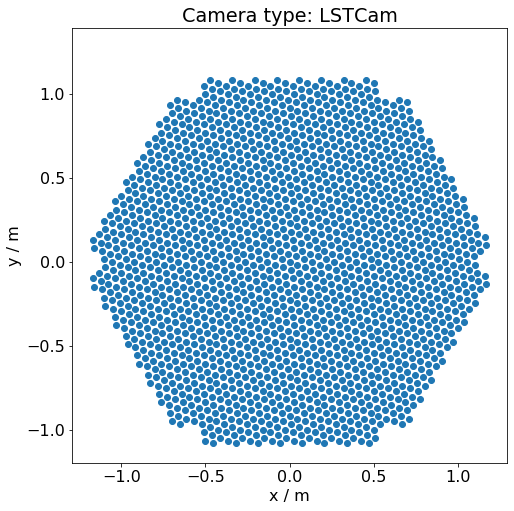

In [10]:
plt.scatter(cam_coords.x, cam_coords.y)
plt.title(f'Camera type: {camera.cam_id}')
plt.xlabel(f'x / {cam_coords.x.unit}')
plt.ylabel(f'y / {cam_coords.y.unit}')
plt.axis('square');

The implementation of the coordinate system with astropy makes it easier to use time of the observation and location of the observing site, to understand, for example which stars are visible during a certain night and how they might be visible in the camera.


Sampling rate is not in file, defaulting to 1.0 GHz


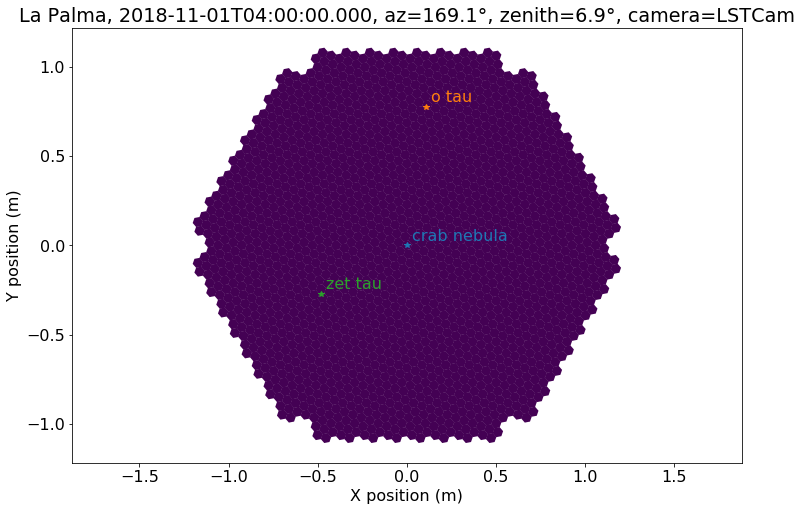

In [11]:
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry

location = EarthLocation.of_site('Roque de los Muchachos')
obstime = Time('2018-11-01T04:00')

crab = SkyCoord.from_name("crab nebula")

altaz = AltAz(location=location, obstime=obstime)

pointing = crab.transform_to(altaz)

camera_frame = CameraFrame(
    telescope_pointing=pointing,
    focal_length=focal_length,
    obstime=obstime,
    location=location,
)

cam = CameraGeometry.from_name('LSTCam')
fig, ax = plt.subplots()
display = CameraDisplay(cam, ax=ax)

ax.set_title(
    f'La Palma, {obstime}, az={pointing.az.deg:.1f}°, zenith={pointing.zen.deg:.1f}°, camera={camera.cam_id}'
)

for i, name in enumerate(['crab nebula', 'o tau', 'zet tau']):
    star = SkyCoord.from_name(name)
    star_cam = star.transform_to(camera_frame)

    x = star_cam.x.to_value(u.m)
    y = star_cam.y.to_value(u.m)

    ax.plot(x, y, marker='*', color=f'C{i}')
    ax.annotate(
        s=name, xy=(x, y), xytext=(5, 5),
        textcoords='offset points', color=f'C{i}',
    )

plt.show()

## TelescopeFrame

Telescope coordinate frame.
A `Frame` using a `UnitSphericalRepresentation`.

This is basically the same as a `HorizonCoordinate`, but the origin is at the telescope's pointing direction.
This is what astropy calls a `SkyOffsetFrame`.

Pointing corrections should applied to the transformation between this frame and the camera frame.

In [12]:
telescope_frame = TelescopeFrame(telescope_pointing=telescope_pointing)
telescope_coords = cam_coords.transform_to(telescope_frame)
print(telescope_coords)

<SkyCoord (TelescopeFrame: telescope_pointing=<AltAz Coordinate (obstime=2013-11-01T03:00:00.000, location=(5327448.9957829, -1718665.73869569, 3051566.90295403) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (5.61512262e-15, 69.99999967)>, obstime=None, location=None): (delta_az, delta_alt) in deg
    [( 0.        ,  0.        ), ( 0.10047038, -0.01933482),
     ( 0.03349124, -0.09667476), ..., (-1.97590405, -1.33415535),
     (-1.90892497, -1.25681546), (-1.80845456, -1.27615028)]>


Text(0, 0.5, 'y / deg')

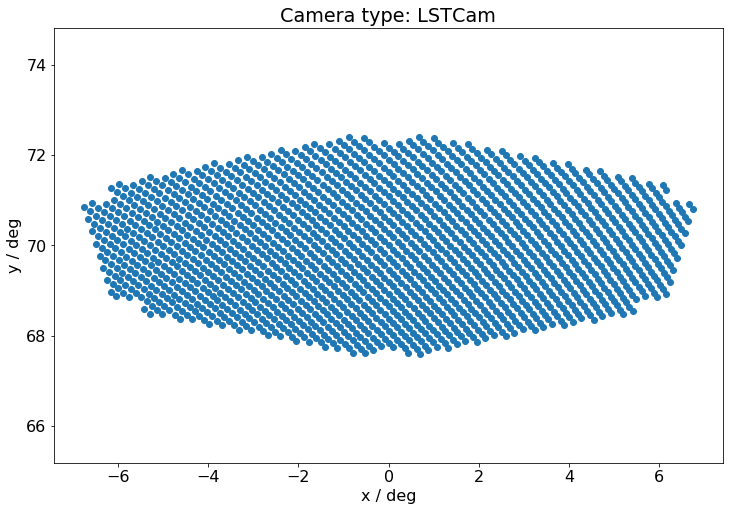

In [13]:
wrap_angle = telescope_pointing.az + 180* u.deg

plt.axis('equal')
plt.scatter(
    telescope_coords.altaz.az.wrap_at(wrap_angle).deg, 
    telescope_coords.altaz.alt.deg
)

plt.title(f'Camera type: {camera.cam_id}')
plt.xlabel('x / {}'.format(telescope_coords.altaz.az.unit))
plt.ylabel('y / {}'.format(telescope_coords.altaz.alt.unit))


## NominalFrame

Nominal coordinate frame.
A Frame using a `UnitSphericalRepresentation`.
This is basically the same as a `HorizonCoordinate`, but the
origin is at an arbitray position in the sky.
This is what astropy calls a `SkyOffsetFrame`
If the telescopes are in divergent pointing, this `Frame` can be
used to transform to a common system.
- 2D reconstruction (`HillasIntersector`) is performed in this frame 
- 3D reconstruction (`HillasReconstructor`) doesn't need this frame

NOTE: here I'm explicitely transforming:

**Camera --> Telescope --> Nominal**

Let's play a bit with 3 MSTs with divergent pointing

In [14]:
location = EarthLocation.of_site('Roque de los Muchachos')
obstime = Time('2018-11-01T02:00')

crab = SkyCoord.from_name("crab nebula")

altaz = AltAz(location=location, obstime=obstime)

array_pointing = crab.transform_to(altaz)

tel_pointings = SkyCoord(
    alt=array_pointing.alt + [1, -1, -1] * u.deg, 
    az=array_pointing.az + [0, -2, +2] * u.deg, 
    frame=altaz,
)

In [15]:
camera_frames = CameraFrame(
    telescope_pointing=tel_pointings,  # multiple pointings, so we get multiple frames
    focal_length=focal_length,
    obstime=obstime,
    location=location,
)

nom_frame = NominalFrame(origin=array_pointing)

cam_coords_1 = SkyCoord(x=pix_x, y=pix_y, frame=camera_frames[0])
cam_coords_2 = SkyCoord(x=pix_x, y=pix_y, frame=camera_frames[1])
cam_coords_3 = SkyCoord(x=pix_x, y=pix_y, frame=camera_frames[2])

nom_coords_1 = cam_coords_1.transform_to(nom_frame)#.transform_to(horizon_frame)
nom_coords_2 = cam_coords_2.transform_to(nom_frame)#.transform_to(horizon_frame)
nom_coords_3 = cam_coords_3.transform_to(nom_frame)#.transform_to(horizon_frame)

If the transformation is done up to the horizon frame then the coordinates are just called with `coord.az` and `coord.alt`.


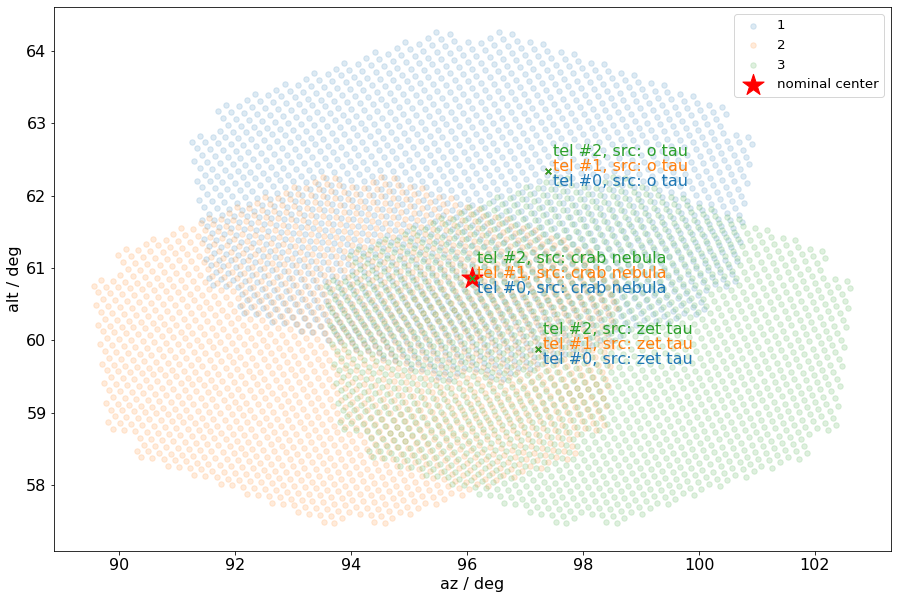

In [16]:
fig, ax = plt.subplots(figsize=(15, 10))

wrap_angle = array_pointing.az + 180* u.deg

for i, coord in enumerate([nom_coords_1, nom_coords_2, nom_coords_3], start = 1):
    ax.scatter(
        x=coord.altaz.az.wrap_at(wrap_angle).deg,
        y=coord.altaz.alt.deg,
        label=str(i),
        s=30,
        alpha=0.15,
    )
    
ax.scatter(nom_frame.origin.az, 
           nom_frame.origin.alt,
           label = "nominal center",
           c = "red",
           marker = '*',
           s = 500
           )    

for i, name in enumerate(['crab nebula', 'o tau', 'zet tau']):
    star = SkyCoord.from_name(name)

    for j, camera_frame in enumerate([camera_frames[0], camera_frames[1], camera_frames[2]]):
        star_cam = star.transform_to(camera_frame)
        altaz_Star = star_cam.transform_to(nom_frame)
        az_plt = altaz_Star.altaz.az.wrap_at(wrap_angle)
        alt_plt =  altaz_Star.altaz.alt
        
        ax.scatter(
            x=az_plt, y=alt_plt,
            marker='x', s=30,
            color=f'C{j}',
        )

        ax.annotate(
           s=f"tel #{j}, src: {name}", xy=(az_plt.value, alt_plt.value), xytext=(5, 15*(j-1)),
           textcoords='offset points', color=f'C{j}',
        )

ax.set_xlabel(f'az / {nom_frame.origin.az.unit}')
ax.set_ylabel(f'alt / {nom_frame.origin.alt.unit}')
    
ax.legend(fontsize="small")
plt.show()

## GroundFrame


Ground coordinate frame.  The ground coordinate frame is a simple
    cartesian frame describing the 3 dimensional position of objects
    compared to the array ground level in relation to the nomial
    centre of the array.  Typically this frame will be used for
    describing the position on telescopes and equipment
    
**Typical usage**: positions of telescopes on the ground (x, y, z)

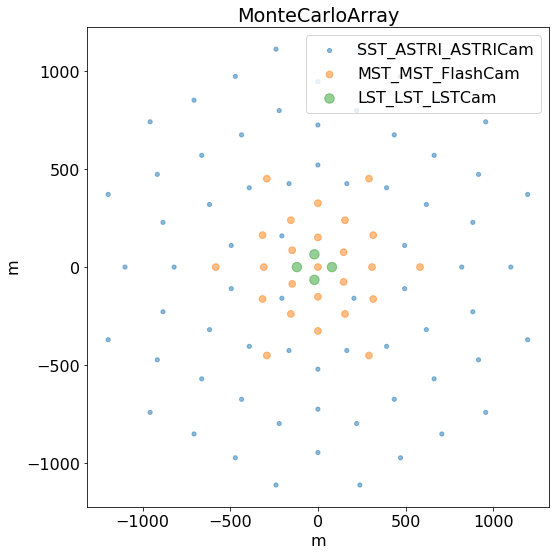

In [17]:
event.inst.subarray.peek()

In case a layout is selected, the following line will produce a different output from the picture above.

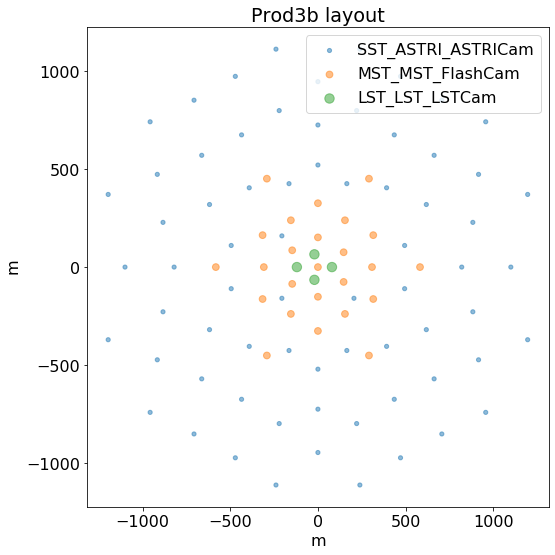

In [18]:
event.inst.subarray.select_subarray("Prod3b layout", layout).peek()

![Ground Frame](ground_frame.png)

In this image all the telescope from the `gamma_test.simtel.gz` file are plotted as spheres in the GroundFrame.

## TiltedGroundFrame

Tilted ground coordinate frame.  

The tilted ground coordinate frame is a cartesian system describing the 2 dimensional projected positions of objects in a tilted plane described by pointing_direction. The plane is rotated along the z_axis by the azimuth of the `pointing_direction` and then it is inclined with an angle equal to the zenith angle of the `pointing_direction`.

This frame is used for the reconstruction of the shower core position.

![Tilted Ground Frame](tilted_ground_frame.png)

This image picture both the telescopes in the GroundFrame (red) and in the TiltedGroundFrame (green) are displayed: in this case since the azimuth of the `pointing_direction` is 0 degrees, then the plane is just tilted according to the zenith angle. 

For playing with these and with more 3D models of the telescopes themselves, have a look at the [CREED_VTK](https://github.com/thomasgas/CREED_VTK) library. 